In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [26]:

num_workers = 0
 
batch_size = 64

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
 download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
 num_workers=num_workers)
print(type(train_loader))


<class 'torch.utils.data.dataloader.DataLoader'>


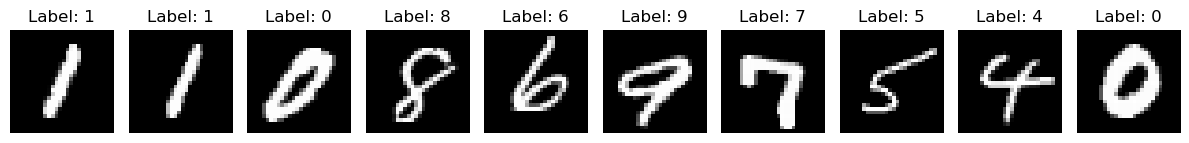

In [12]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))

for i in range(num_samples):
    # Get a random image and its corresponding label
    index = torch.randint(len(train_data), size=(1,)).item()
    image, label = train_data[index]
    image = image.squeeze().numpy()

    # Display the image
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()






        



In [13]:
class Discriminator(nn.Module):
   def __init__(self, input_size, hidden_dim, output_size):
     super(Discriminator, self).__init__()
 
 
     self.fc1 = nn.Linear(input_size, hidden_dim*4)
     self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
     self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
 
 
     self.fc4 = nn.Linear(hidden_dim, output_size)
 
   
     self.dropout = nn.Dropout(0.3)
 
 
   def forward(self, x):
  
     x = x.view(-1, 28*28)
 
     x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
     x = self.dropout(x)
     x = F.leaky_relu(self.fc2(x), 0.2)
     x = self.dropout(x)
     x = F.leaky_relu(self.fc3(x), 0.2)
     x = self.dropout(x)

     out = self.fc4(x)
     return out

In [14]:
class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
 
 
    self.fc1 = nn.Linear(input_size, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
 
 
    self.fc4 = nn.Linear(hidden_dim*4, output_size)
 
 
    self.dropout = nn.Dropout(0.3)
  def forward(self, x):
  
   x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
   x = self.dropout(x)
   x = F.leaky_relu(self.fc2(x), 0.2)
   x = self.dropout(x)
   x = F.leaky_relu(self.fc3(x), 0.2)
   x = self.dropout(x)
   out = F.tanh(self.fc4(x))
   return out

In [15]:
 
input_size = 784 
d_output_size = 1
 
d_hidden_size = 32

 
z_size = 100
 
g_output_size = 784
 
g_hidden_size = 32

In [16]:
D = Discriminator(784, 32, 1)
G = Generator(100,32,784)
print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [17]:
def real_loss(D_out, smooth=False):
 batch_size = D_out.size(0)
 
 if smooth:
   labels = torch.ones(batch_size)*0.9
 else:
   labels = torch.ones(batch_size) 
 
 
 criterion = nn.BCEWithLogitsLoss()

 loss = criterion(D_out.squeeze(), labels)
 return loss

def fake_loss(D_out):
 batch_size = D_out.size(0)
 labels = torch.zeros(batch_size) 
 criterion = nn.BCEWithLogitsLoss()

 loss = criterion(D_out.squeeze(), labels)
 return loss

In [18]:
import torch.optim as optim
lr = 0.002
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

FINAL TRAINING PROCESS


In [19]:
import pickle as pkl

 
num_epochs = 100

 
samples = []
losses = []

print_every = 400

 
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

 
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        
        real_images = real_images*2 - 1  
        d_optimizer.zero_grad()
        
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
         
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
       
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
         
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        g_optimizer.zero_grad()
        
 
     
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
     
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) 
         
        g_loss.backward()
        g_optimizer.step()

        
        if batch_i % print_every == 0:
          
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
           
    losses.append((d_loss.item(), g_loss.item()))
    
     
    G.eval()  
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()  


 
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

    
        


Epoch [    1/  100] | d_loss: 1.3829 | g_loss: 0.7615


Epoch [    1/  100] | d_loss: 1.6297 | g_loss: 0.4322
Epoch [    1/  100] | d_loss: 0.9635 | g_loss: 3.3646
Epoch [    2/  100] | d_loss: 1.4367 | g_loss: 0.7226
Epoch [    2/  100] | d_loss: 0.9368 | g_loss: 2.2990
Epoch [    2/  100] | d_loss: 0.8861 | g_loss: 1.6641
Epoch [    3/  100] | d_loss: 1.1672 | g_loss: 0.9357
Epoch [    3/  100] | d_loss: 0.9394 | g_loss: 1.6423
Epoch [    3/  100] | d_loss: 0.9730 | g_loss: 1.2372
Epoch [    4/  100] | d_loss: 1.0729 | g_loss: 2.9850
Epoch [    4/  100] | d_loss: 1.1519 | g_loss: 1.1254
Epoch [    4/  100] | d_loss: 1.3434 | g_loss: 1.0210
Epoch [    5/  100] | d_loss: 1.2455 | g_loss: 1.2188
Epoch [    5/  100] | d_loss: 1.1303 | g_loss: 1.4055
Epoch [    5/  100] | d_loss: 1.3425 | g_loss: 1.0817
Epoch [    6/  100] | d_loss: 1.4596 | g_loss: 0.8944
Epoch [    6/  100] | d_loss: 1.1912 | g_loss: 1.1119
Epoch [    6/  100] | d_loss: 0.9494 | g_loss: 2.3388
Epoch [    7/  100] | d_loss: 1.1838 | g_loss: 2.1331
Epoch [    7/  100] | d_loss

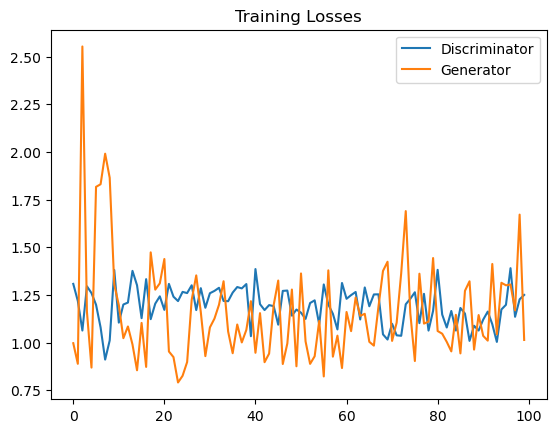

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [31]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [32]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)


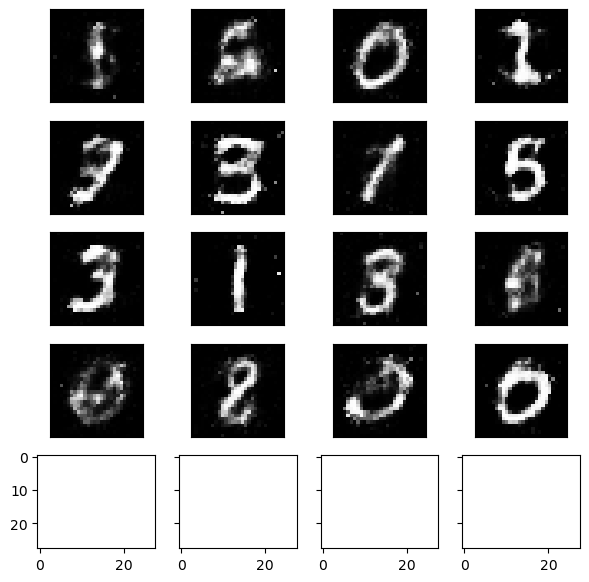

In [33]:
view_samples(-1, samples)

CREATING RANDOM IMAGES USING THE GENERATOR

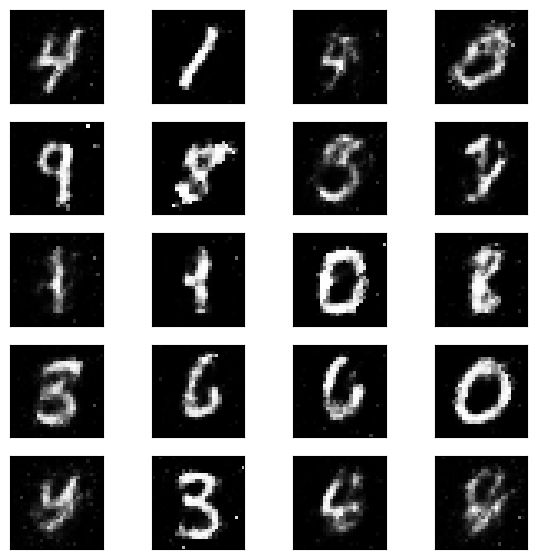

In [34]:
sample_size = 20
rand_z = np.random.uniform(-1,1, size=(sample_size,z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval()
rand_images = G(rand_z)

view_samples(0,[rand_images])

